# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project we apply methods like region masking, canny detection and Hough transform to detect lanes in an image as well as video. A camera is mounted on top of the car. It is used to capture images. Then this image is processed to detect lane line on the road. The lane lines can have different widths and colour. Some of them maybe bright and some may be dull in colour. So self-driving car should check all this conditions and accordingly travel on the correct path.


---

## Import Packages

In [20]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


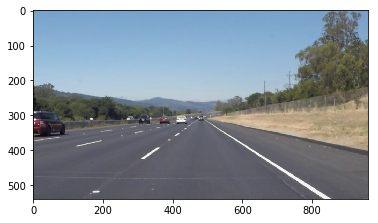

In [21]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that are  be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image



## Helper Functions

In [22]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


    
def draw_lines(img, lines, vertices,color=[255, 0, 0], thickness=15):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    right_lane=[]; #list for vertices on right lane
    left_lane=[]; # #list for vertices on left lane
    for line in lines:
        for x1,y1,x2,y2 in line:
            if(x2-x1==0): 
                continue;
            else:
                m = (y2-y1) / (x2-x1)  #calculating slope of detected lines
            if abs(m) < 0.4:   #check for the line in yellowcurved video
                continue
            if(m>0):
                right_lane.append((x1,y1))  #append vertices of lines in right lane
                right_lane.append((x2,y2))  #append vertices of lines in right lane
            if(m<0):
                left_lane.append((x1,y1))   #append vertices of lines in left lane
                left_lane.append((x2,y2))   #append vertices of lines in left lane   
    
    if(len(left_lane)>=2):
        left_lane = np.array(left_lane)
        x=left_lane[:,0]
        y=left_lane[:,1]
        m,c=np.polyfit(x,y,1)  #get average slope and contant of line

        left_bottom_y=vertices[0][0][1]   #getting y cordinate of the bottom left region of interest
        left_top_y=vertices[0][1][1]      #getting y cordinate of the top left region of interest
        left_bottom_x=int((left_bottom_y-c)/m)  #calculating x cordinate of bottom left region
        left_top_x=int((left_top_y-c)/m)    #calculating x cordinate of top left region
        cv2.line(img, (left_top_x, left_top_y), (left_bottom_x, left_bottom_y), color, thickness)  #draws line 
    
    if(len(right_lane)>=2):
        right_lane = np.array(right_lane)
        x=right_lane[:,0]
        #print(x)
        y=right_lane[:,1]
        m,c=np.polyfit(x,y,1)  #get average slope and contant of line

        right_top_y =vertices[0][3][1] #getting y cordinate of the top right region of interest
        right_bottom_y=vertices[0][2][1]  #getting y cordinate of the bottom right region of interest
        right_bottom_x=int((right_bottom_y-c)/m)  #calculating x cordinate of bottom right region
        right_top_x=int((right_top_y-c)/m)   #calculating x cordinate of top right region
        cv2.line(img, (right_top_x, right_top_y), (right_bottom_x, right_bottom_y), color, thickness) #draws line 


def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

## Test Images



In [23]:
import os
test_images=os.listdir("test_images/")
print(test_images)

['solidWhiteCurve.jpg', 'solidWhiteRight.jpg', 'solidYellowCurve.jpg', 'solidYellowCurve2.jpg', 'solidYellowLeft.jpg', 'whiteCarLaneSwitch.jpg']


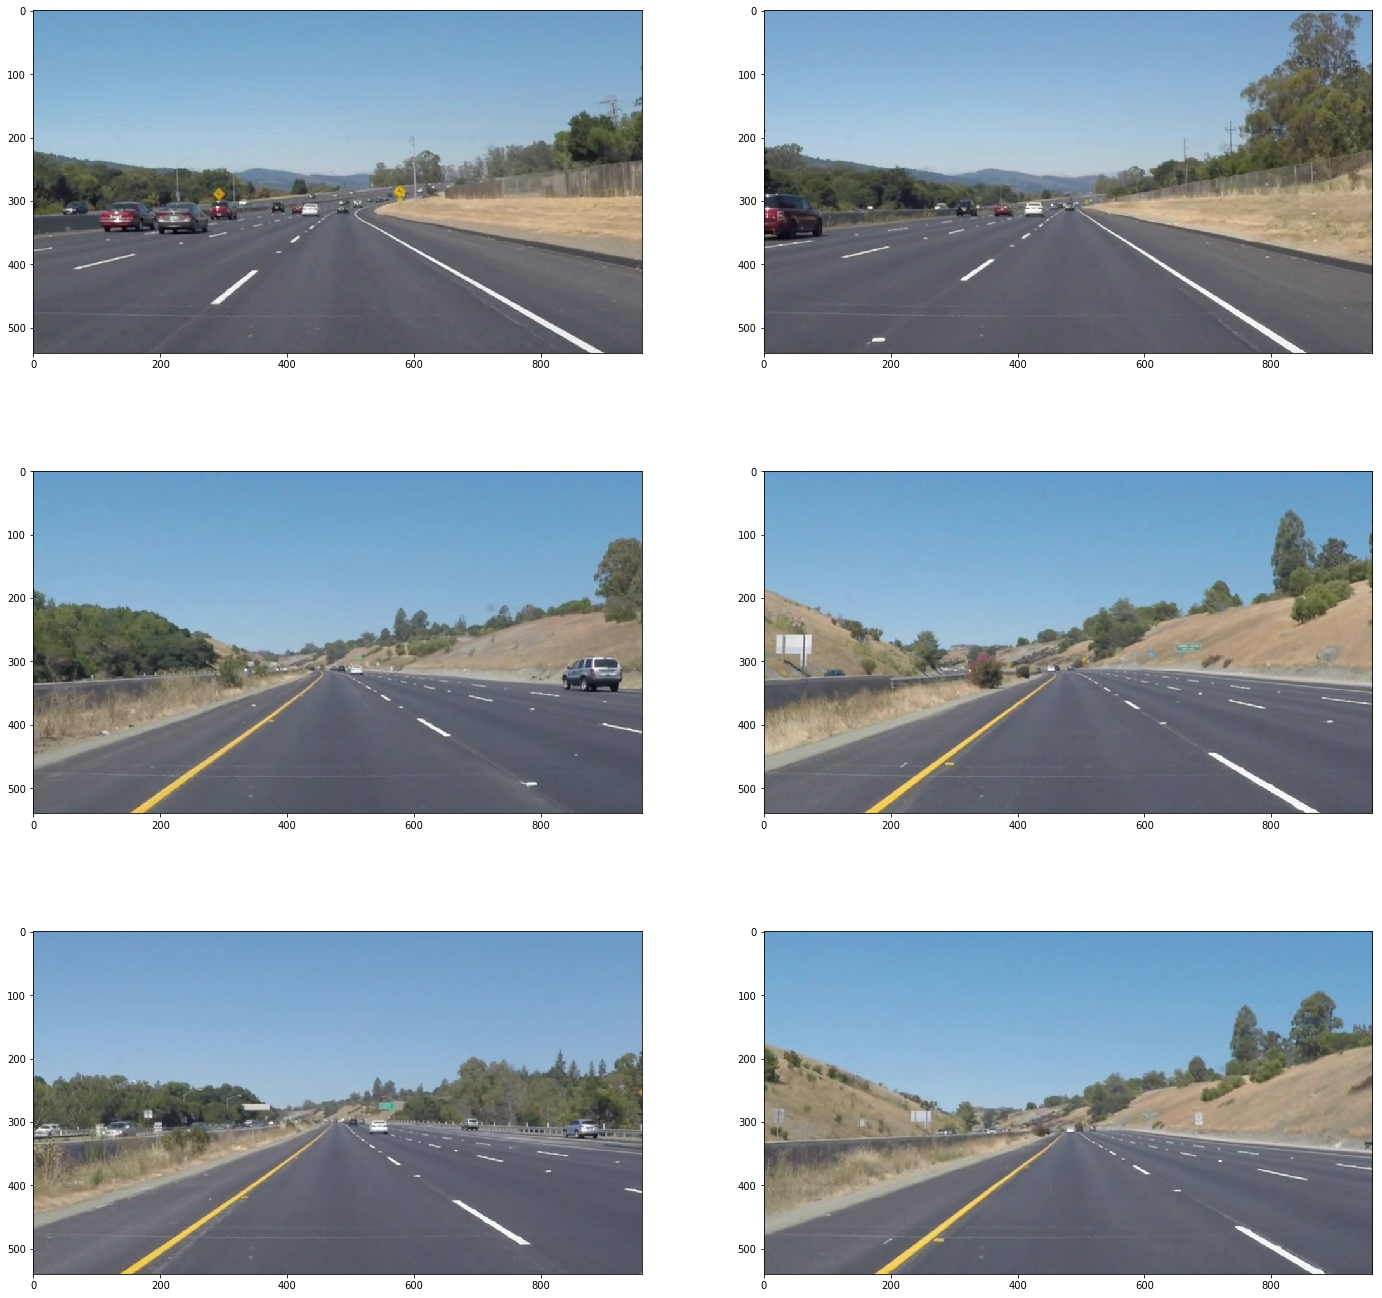

In [24]:
f, ax = plt.subplots(3,2,figsize=(24, 24))
ax[0,0].imshow(mpimg.imread("test_images/"+test_images[0]))
ax[0,1].imshow(mpimg.imread("test_images/"+test_images[1]))
ax[1,0].imshow(mpimg.imread("test_images/"+test_images[2]))
ax[1,1].imshow(mpimg.imread("test_images/"+test_images[3]))
ax[2,0].imshow(mpimg.imread("test_images/"+test_images[4]))
ax[2,1].imshow(mpimg.imread("test_images/"+test_images[5]))

## Setting parameters

In [25]:

image=mpimg.imread("test_images/"+test_images[0])
y = image.shape[0]
x = image.shape[1]
vertices = np.array([[(0, y), (x*0.4, y*0.6), (x*0.6, y*0.6), (x, y)]], np.int32)
low_threshold=50       #parameters for canny detection 
high_threshold=150     #parameters for canny detection
kernel_size=7         #kernel size for Gaussian smoothing / blurring
rho = 1 # distance resolution in pixels  from origin in hough space
theta = np.pi/180 # angular resolution in radians of the Hough space wrt origin
threshold = 40     # minimum number of votes 
min_line_length = 100 #minimum number of pixels to make a line
max_line_gap = 300   # maximum gap in pixels between lines that can be connected 


## Convert to gray scale image

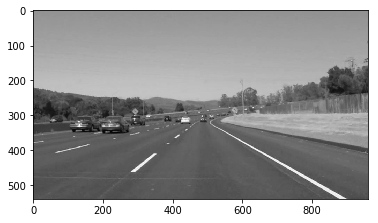

In [26]:
gray_image=grayscale(image)   #conversion to grayscale image
plt.imshow(gray_image,cmap='gray') 

## Remove some noise using guassian blur

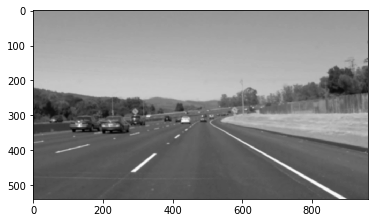

In [27]:

blur_image=gaussian_blur(gray_image,kernel_size)   # gaussian_blur suppress noise and spurious gradients by averaging 
plt.imshow(blur_image,cmap='gray') 

## Detect edges

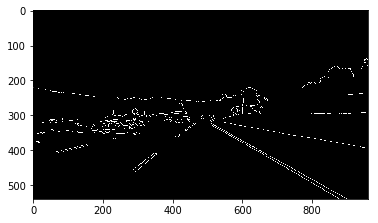

In [28]:
edges=canny(blur_image,low_threshold,high_threshold) #gets image with edges in image
plt.imshow(edges,cmap='gray') 

## Mask the required region

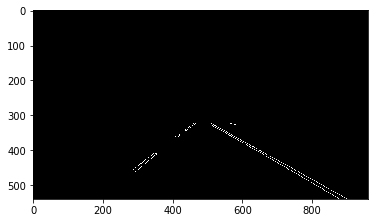

In [29]:
masked_image=region_of_interest(edges,vertices) #gets image with edges in region of interest
plt.imshow(masked_image,cmap='gray') 

## Draw the lines on the image

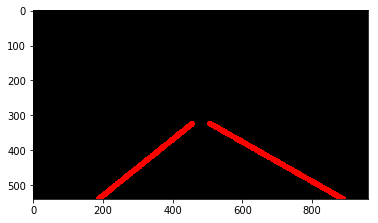

In [30]:
lines = cv2.HoughLinesP(masked_image, rho, theta, threshold, np.array([]), min_line_length, max_line_gap) #gets image with edges having line segments
line_image = np.zeros((masked_image.shape[0], masked_image.shape[1], 3), dtype=np.uint8) 
draw_lines(line_image, lines,vertices)  #extrapolate line
plt.imshow(line_image) 

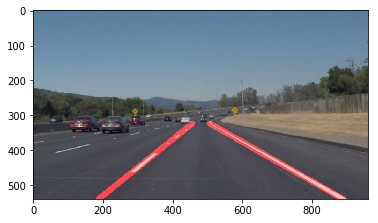

In [31]:
result=weighted_img(line_image, image, α=0.8, β=1., γ=0.)  #add color to the line in the image
plt.imshow(result) 

## Build a Lane Finding Pipeline



In [32]:

def process_image(image): 
    y = image.shape[0]
    x = image.shape[1]
    vertices = np.array([[(0, y), (x*0.4, y*0.6), (x*0.6, y*0.6), (x, y)]], np.int32)
    low_threshold=50       #parameters for canny detection 
    high_threshold=150     #parameters for canny detection
    kernel_size=7         #kernel size for Gaussian smoothing / blurring
    rho = 1 # distance resolution in pixels  from origin in hough space
    theta = np.pi/180 # angular resolution in radians of the Hough space wrt origin
    threshold = 40     # minimum number of votes 
    min_line_length = 100 #minimum number of pixels to make a line
    max_line_gap = 300   # maximum gap in pixels between lines that can be connected 
    gray_image=grayscale(image)   #conversion to grayscale image
    blur_image=gaussian_blur(gray_image,kernel_size)   # gaussian_blur suppress noise and spurious gradients by averaging 
    edges=canny(blur_image,low_threshold,high_threshold) #gets image with edges in image
    masked_image=region_of_interest(edges,vertices) #gets image with edges in region of interest
    lines = cv2.HoughLinesP(masked_image, rho, theta, threshold, np.array([]), min_line_length, max_line_gap) #gets image with edges having line segments
    line_image = np.zeros((masked_image.shape[0], masked_image.shape[1], 3), dtype=np.uint8) 
    draw_lines(line_image, lines,vertices)  #extrapolate line
    result=weighted_img(line_image, image, α=0.8, β=1., γ=0.)  #add color to the line in the image
    plt.imshow(result) 
    return result



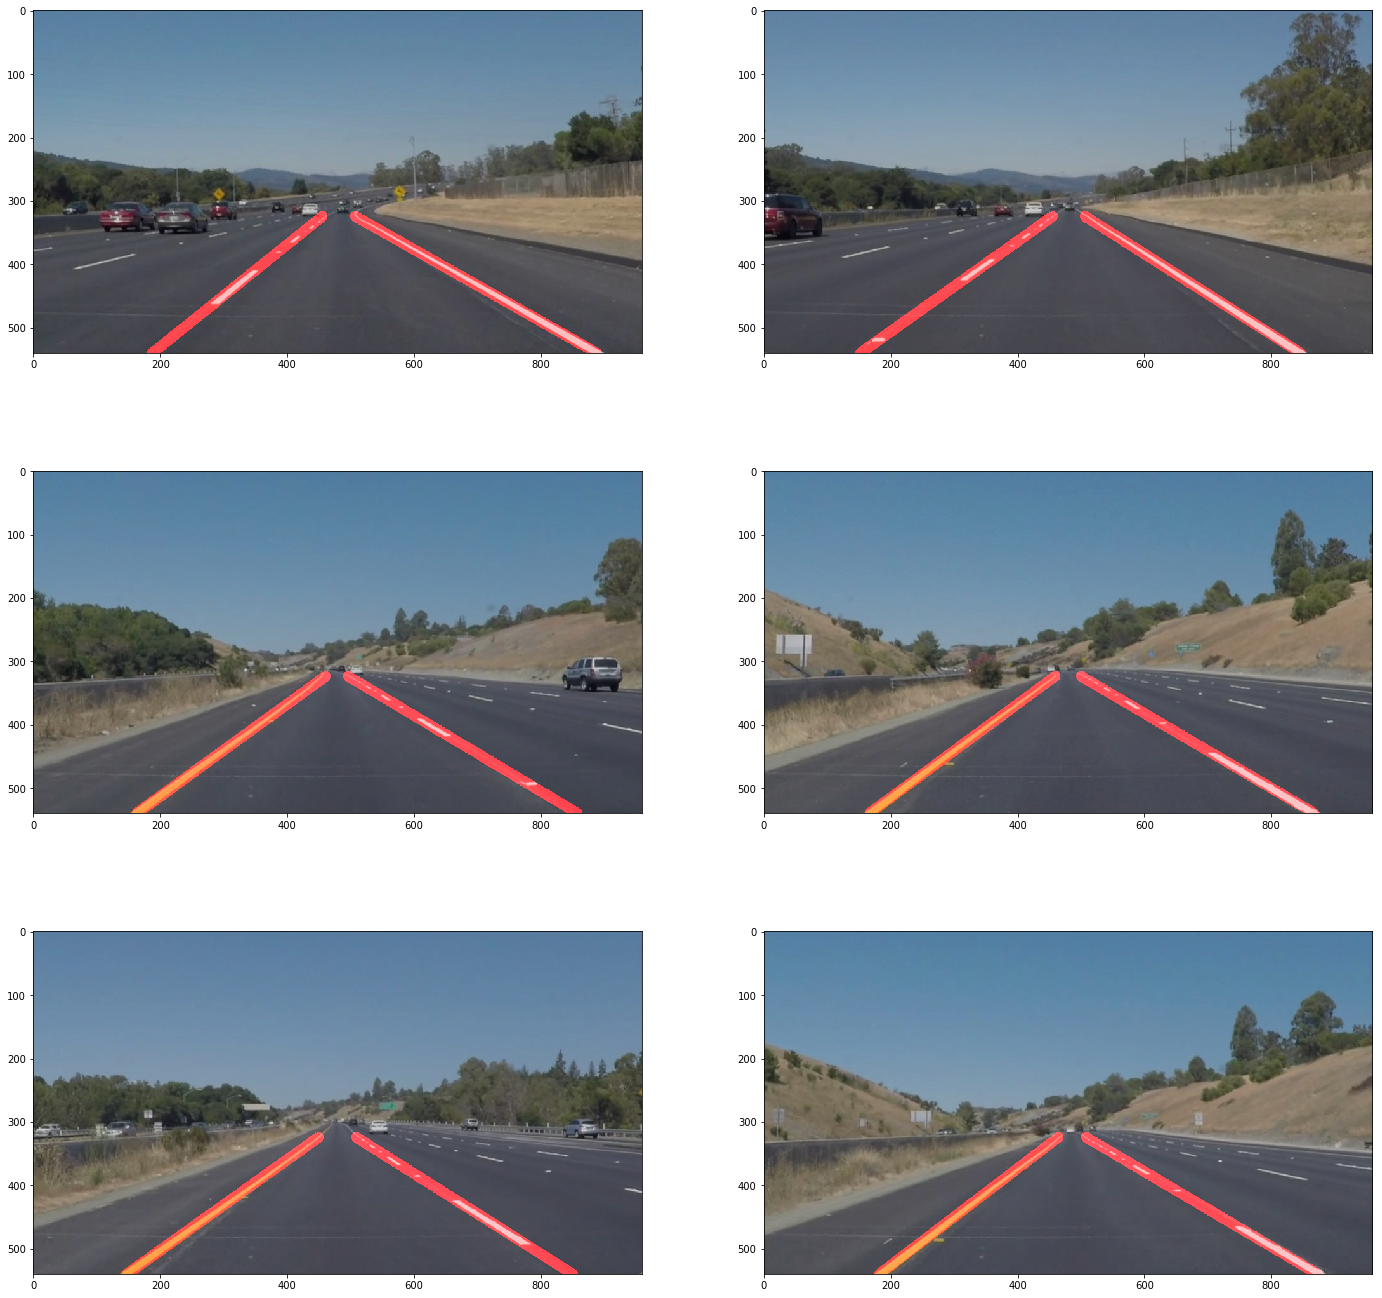

In [33]:
output_images=[]
f, ax = plt.subplots(3,2,figsize=(24, 24))
for i in test_images:
    image = mpimg.imread('test_images/'+i)
    output_images.append(process_image(image))
    

ax[0,0].imshow(output_images[0])
ax[0,1].imshow(output_images[1])
ax[1,0].imshow(output_images[2])
ax[1,1].imshow(output_images[3])
ax[2,0].imshow(output_images[4])
ax[2,1].imshow(output_images[5])    

## Test on Videos

In [34]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

Let's try the one with the solid white lane on the right first ...

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|███████████████████████████████████████▊| 221/222 [00:13<00:00, 19.46it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

Wall time: 15 s


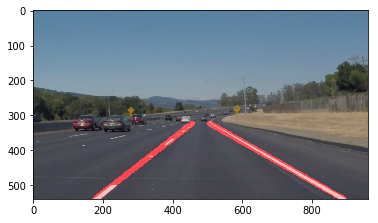

In [35]:
import os

from moviepy.video.VideoClip import VideoClip

white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [36]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

Now for the one with the solid yellow lane on the left. This one's more tricky!

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|███████████████████████████████████████▉| 681/682 [00:46<00:00, 14.59it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

Wall time: 48.4 s


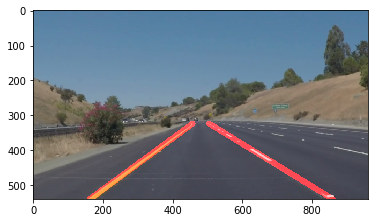

In [37]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

In [38]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Potential shortcomings with current pipeline
This method can only detect straight roads. This function will not work fine when there are curve roads, turns, roadblocks, U-turns, steep roads (both up and down). It will not work when the intensity of light exceeds the brightness of lanes as canny edge detector will not be able to identify the gradient.

## Possible improvement for pipeline
Apply better region masking for steep roads: Detecting horizontal line which separates sky and roads so that we can know up to where lines should extend.
For curved roads: Apply degree of order more than 1 to detect curved lines
For light intensity: Detect colour of lanes using HSL